In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

2024-03-16 09:41:44.181280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 09:41:44.181439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 09:41:44.328913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel1(noOfClasses):
    modelInput = tf.keras.applications.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
    ]
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'EfficientNetB0.keras', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint





In [6]:
def modelFit(model, annealer, checkpoint):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=gEpochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[7]*100
    TP = evl[1]
    FP = evl[2]
    FN = evl[4]
    TN = evl[3]
    prec = evl[5]
    rec = evl[6]
    F1 = 100 * ((2 * prec * rec) / (prec + rec))
    auc = evl[8]
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    msg+=f'\nTrue Positives = {TP}. True Negatives = {TN}'
    msg+=f'\nFalse Positives = {FP}. False Negatives = {FN}'
    msg+=f'\nPrecision = {prec}'
    msg+=f'\nRecall = {rec}'
    msg+=f'\nF1 Score = {F1}'
    msg+=f'\nROC AUC = {auc}'
    print(msg)
    
def saveModel(model, className):
    save_path = "/kaggle/working/" + className + " - EfficientNetB0.keras"
    model.save(save_path)
    print("Model saved at:", save_path)

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [10]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")
    def objective_function(hyperparameters):
        lr,batch = hyperparameters
        accuracy = accuracy_score(y_true,y_pred)
        return -accuracy
    
    accuracy = accuracy_score(y_true, y_pred)
    search_space = [(1e-4, 1e-2), (32, 256)]
    result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')
    best_hyperparameters = result.x
    print("Best Hyperparameters (learning rate, batch size):", best_hyperparameters)

In [11]:
mpath = r'../input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
batchSize = 64
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normaliza

2024-03-16 09:42:50.502246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/547 [..............................] - ETA: 1:45:29 - loss: 1.6939 - tp: 0.0000e+00 - fp: 3.0000 - tn: 125.0000 - fn: 32.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.1562 - auc: 0.5367

I0000 00:00:1710582174.327360     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 [==============================] - ETA: 0s - loss: 0.3770 - tp: 14337.0000 - fp: 1029.0000 - tn: 68971.0000 - fn: 3163.0000 - precision: 0.9330 - recall: 0.8193 - accuracy: 0.8797 - auc: 0.9855
Epoch 1: val_loss improved from inf to 0.18434, saving model to Cervical Cancer EfficientNetB0.keras
547/547 [==============================] - 251s 439ms/step - loss: 0.3770 - tp: 14337.0000 - fp: 1029.0000 - tn: 68971.0000 - fn: 3163.0000 - precision: 0.9330 - recall: 0.8193 - accuracy: 0.8797 - auc: 0.9855 - val_loss: 0.1843 - val_tp: 7000.0000 - val_fp: 256.0000 - val_tn: 29744.0000 - val_fn: 500.0000 - val_precision: 0.9647 - val_recall: 0.9333 - val_accuracy: 0.9513 - val_auc: 0.9968 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 0.1678 - tp: 16463.0000 - fp: 567.0000 - tn: 69433.0000 - fn: 1037.0000 - precision: 0.9667 - recall: 0.9407 - accuracy: 0.9549 - auc: 0.9973
Epoch 2: val_loss improved from 0.18434 to 0.11565, saving model to Cervical C

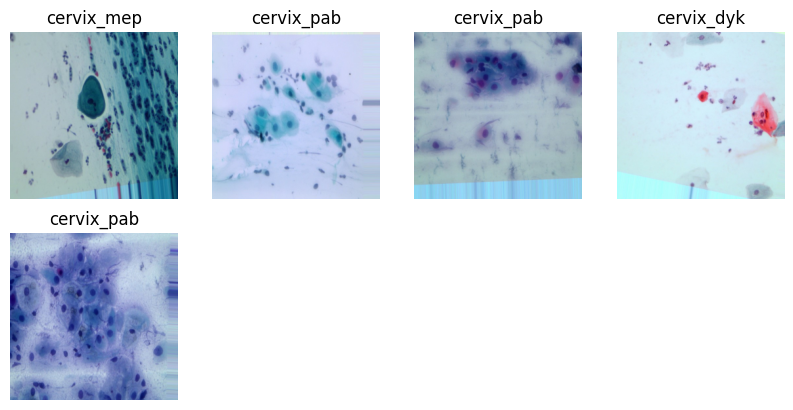

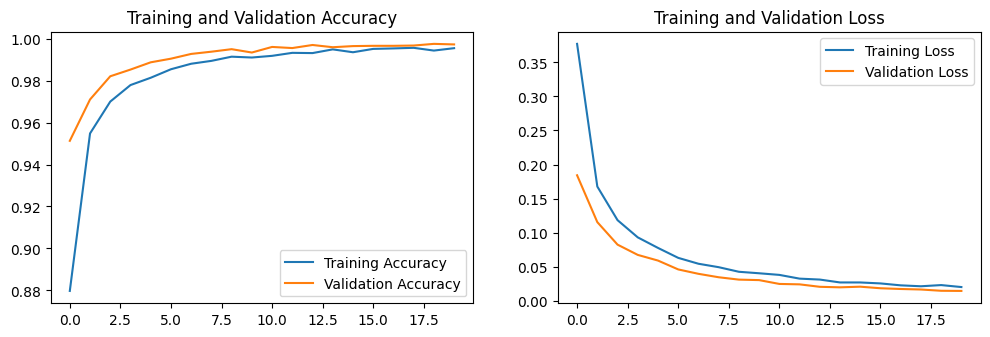

235/235 [==============================] - 27s 113ms/step - loss: 0.0148 - tp: 7476.0000 - fp: 15.0000 - tn: 29985.0000 - fn: 24.0000 - precision: 0.9980 - recall: 0.9968 - accuracy: 0.9973 - auc: 1.0000
Accuracy on the Test Set = 99.73 %
True Positives = 7476.0. True Negatives = 29985.0
False Positives = 15.0. False Negatives = 24.0
Precision = 0.9979975819587708
Recall = 0.9968000054359436
F1 Score = 99.7398434214887
ROC AUC = 0.9999871850013733
Model saved at: /kaggle/working/Cervical Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 28s 111ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

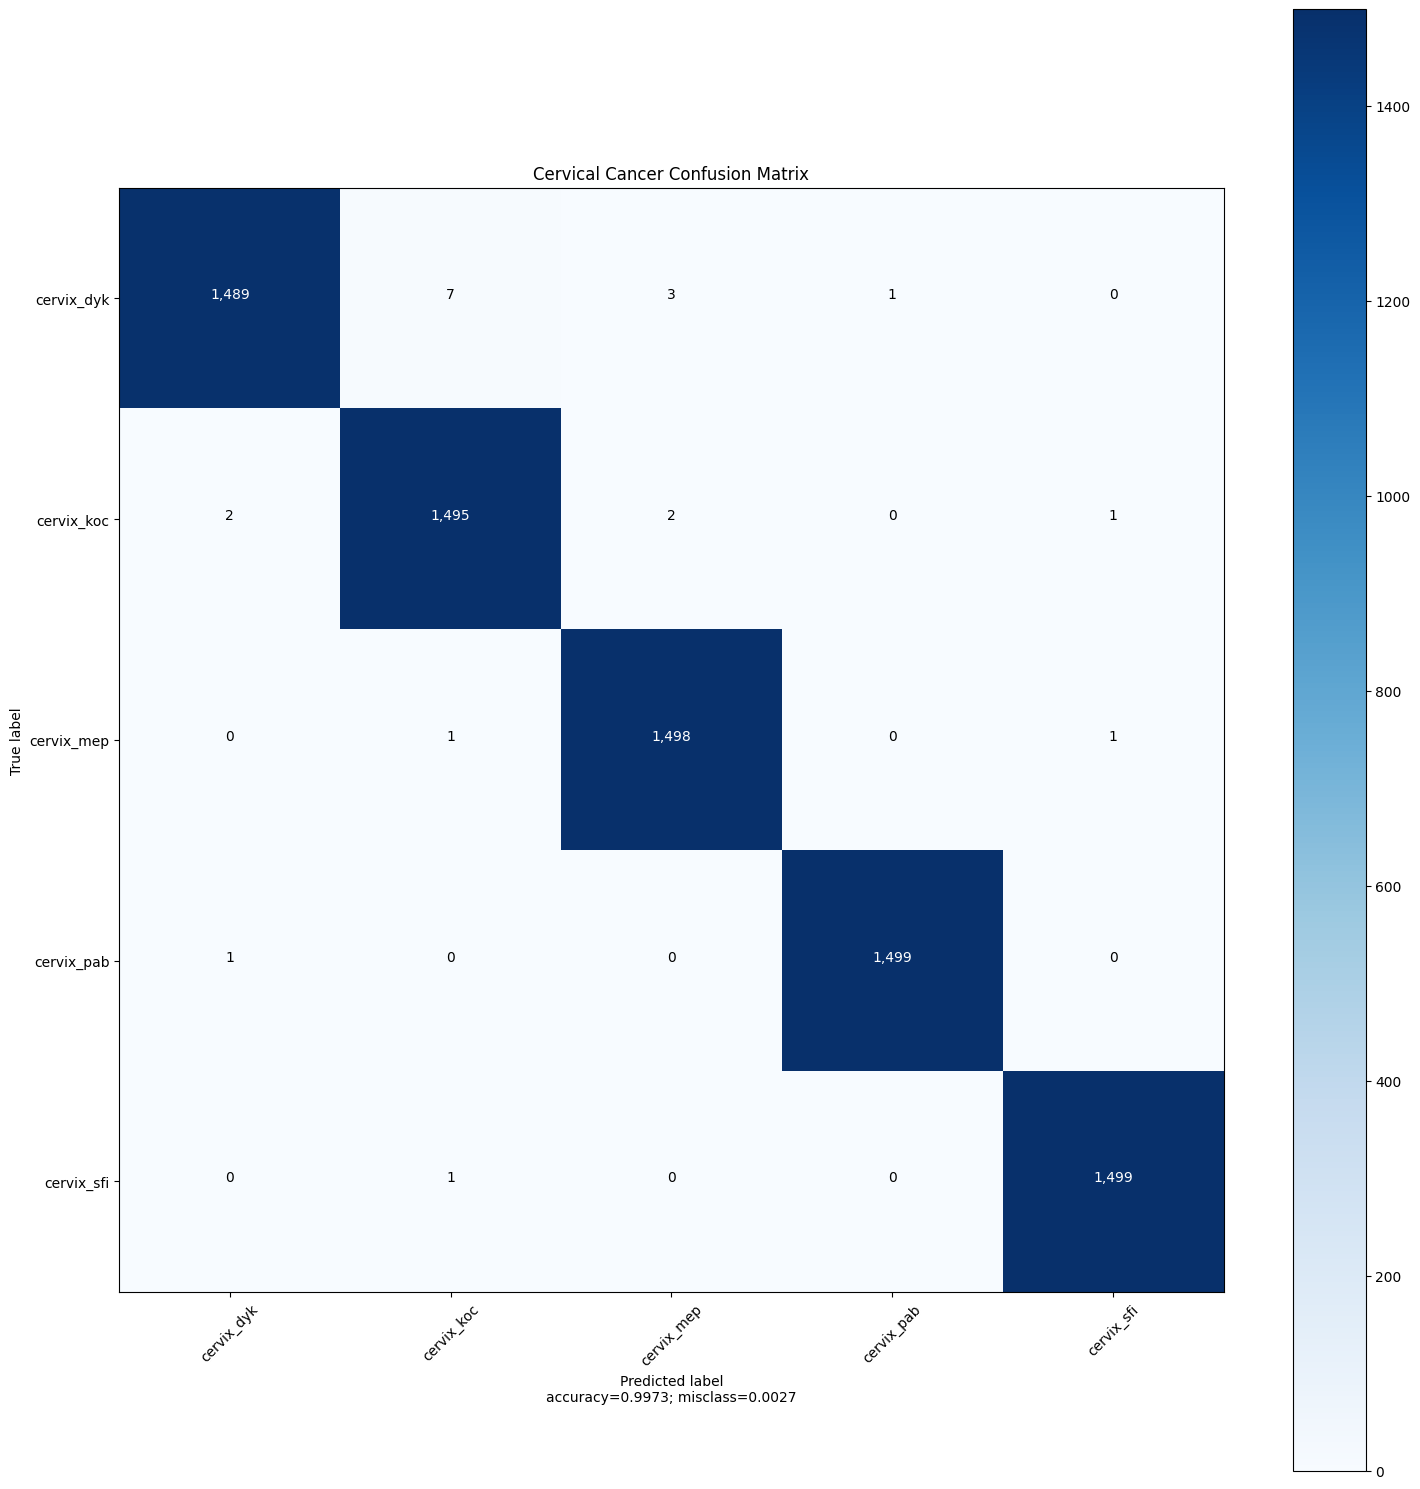

Best Hyperparameters (learning rate, batch size): [9.95284737e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [12]:
className = 'Cervical Cancer '
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']       

2024-03-16 10:16:51.478847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


547/547 [==============================] - ETA: 0s - loss: 0.2114 - tp: 15898.0000 - fp: 696.0000 - tn: 69304.0000 - fn: 1602.0000 - precision: 0.9581 - recall: 0.9085 - accuracy: 0.9374 - auc: 0.9958
Epoch 1: val_loss improved from inf to 0.08618, saving model to Lung And Colon Cancer EfficientNetB0.keras
547/547 [==============================] - 249s 441ms/step - loss: 0.2114 - tp: 15898.0000 - fp: 696.0000 - tn: 69304.0000 - fn: 1602.0000 - precision: 0.9581 - recall: 0.9085 - accuracy: 0.9374 - auc: 0.9958 - val_loss: 0.0862 - val_tp: 7274.0000 - val_fp: 187.0000 - val_tn: 29813.0000 - val_fn: 226.0000 - val_precision: 0.9749 - val_recall: 0.9699 - val_accuracy: 0.9731 - val_auc: 0.9993 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 0.0838 - tp: 17007.0000 - fp: 445.0000 - tn: 69555.0000 - fn: 493.0000 - precision: 0.9745 - recall: 0.9718 - accuracy: 0.9732 - auc: 0.9992
Epoch 2: val_loss improved from 0.08618 to 0.06282, saving model to Lung An

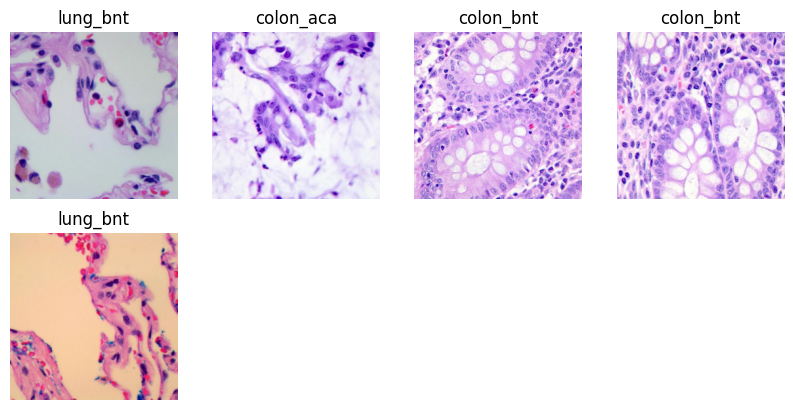

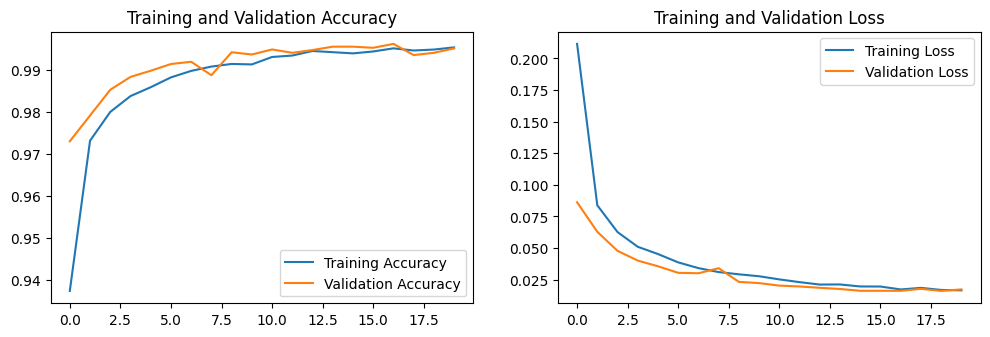

235/235 [==============================] - 29s 124ms/step - loss: 0.0173 - tp: 7463.0000 - fp: 36.0000 - tn: 29964.0000 - fn: 37.0000 - precision: 0.9952 - recall: 0.9951 - accuracy: 0.9952 - auc: 1.0000
Accuracy on the Test Set = 99.52 %
True Positives = 7463.0. True Negatives = 29964.0
False Positives = 36.0. False Negatives = 37.0
Precision = 0.9951993823051453
Recall = 0.9950666427612305
F1 Score = 99.51330081066976
ROC AUC = 0.9999589323997498
Model saved at: /kaggle/working/Lung And Colon Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 29s 117ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

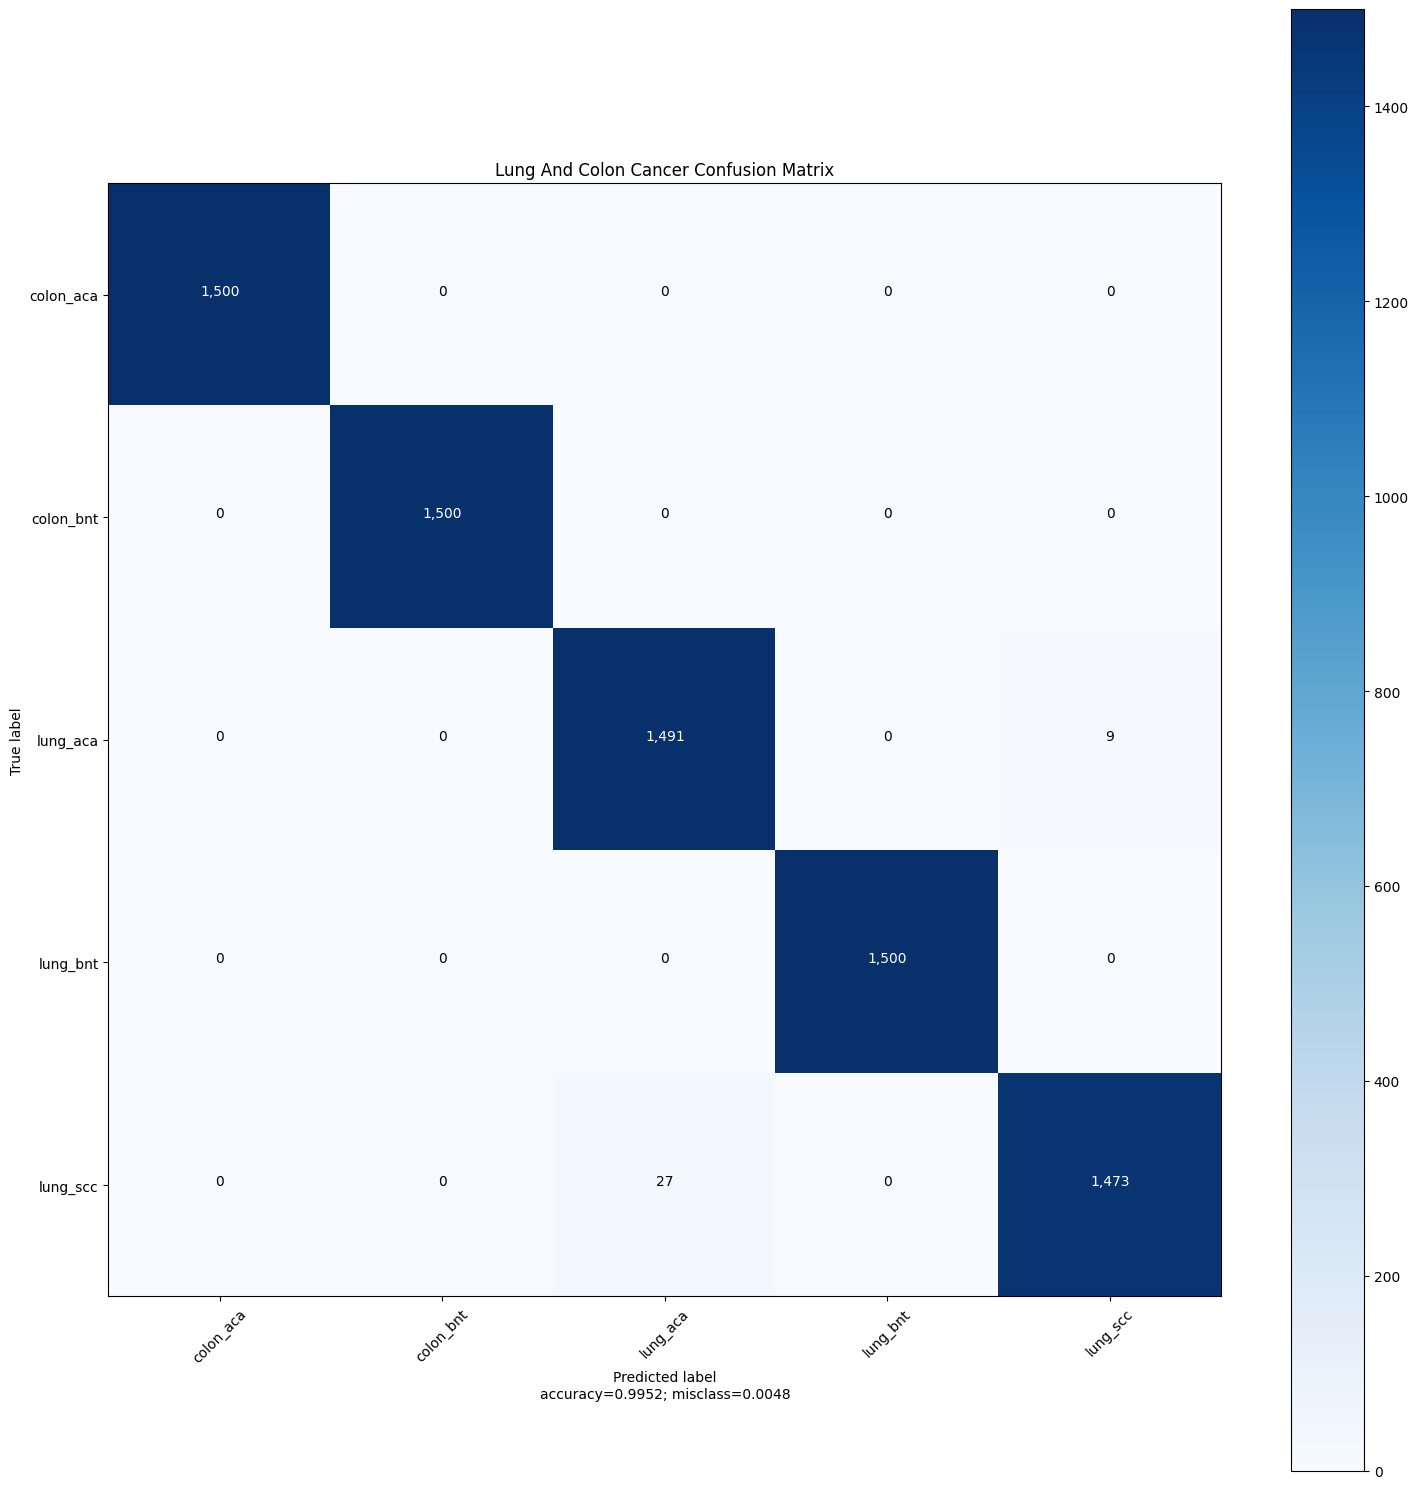

Best Hyperparameters (learning rate, batch size): [9.95285439e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [13]:
className = 'Lung And Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 7002 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                           

2024-03-16 10:53:38.892012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - ETA: 0s - loss: 0.4954 - tp: 5307.0000 - fp: 1695.0000 - tn: 5307.0000 - fn: 1695.0000 - precision: 0.7579 - recall: 0.7579 - accuracy: 0.7579 - auc: 0.8406
Epoch 1: val_loss improved from inf to 0.41613, saving model to Oral Cancer EfficientNetB0.keras
219/219 [==============================] - 111s 469ms/step - loss: 0.4954 - tp: 5307.0000 - fp: 1695.0000 - tn: 5307.0000 - fn: 1695.0000 - precision: 0.7579 - recall: 0.7579 - accuracy: 0.7579 - auc: 0.8406 - val_loss: 0.4161 - val_tp: 2432.0000 - val_fp: 568.0000 - val_tn: 2432.0000 - val_fn: 568.0000 - val_precision: 0.8107 - val_recall: 0.8107 - val_accuracy: 0.8107 - val_auc: 0.8968 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - ETA: 0s - loss: 0.3928 - tp: 5780.0000 - fp: 1222.0000 - tn: 5780.0000 - fn: 1222.0000 - precision: 0.8255 - recall: 0.8255 - accuracy: 0.8255 - auc: 0.9088
Epoch 2: val_loss improved from 0.41613 to 0.37514, saving model to Oral Cancer Efficien

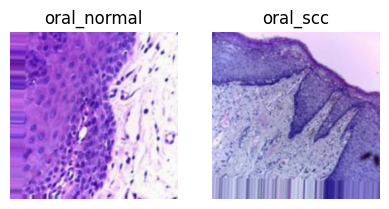

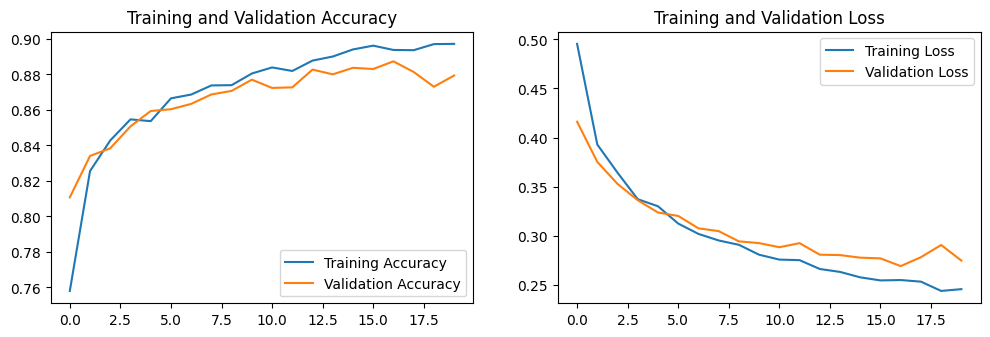

94/94 [==============================] - 11s 121ms/step - loss: 0.2746 - tp: 2638.0000 - fp: 362.0000 - tn: 2638.0000 - fn: 362.0000 - precision: 0.8793 - recall: 0.8793 - accuracy: 0.8793 - auc: 0.9541
Accuracy on the Test Set = 87.93 %
True Positives = 2638.0. True Negatives = 2638.0
False Positives = 362.0. False Negatives = 362.0
Precision = 0.8793333172798157
Recall = 0.8793333172798157
F1 Score = 87.93333172798157
ROC AUC = 0.9540966749191284
Model saved at: /kaggle/working/Oral Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 13s 115ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

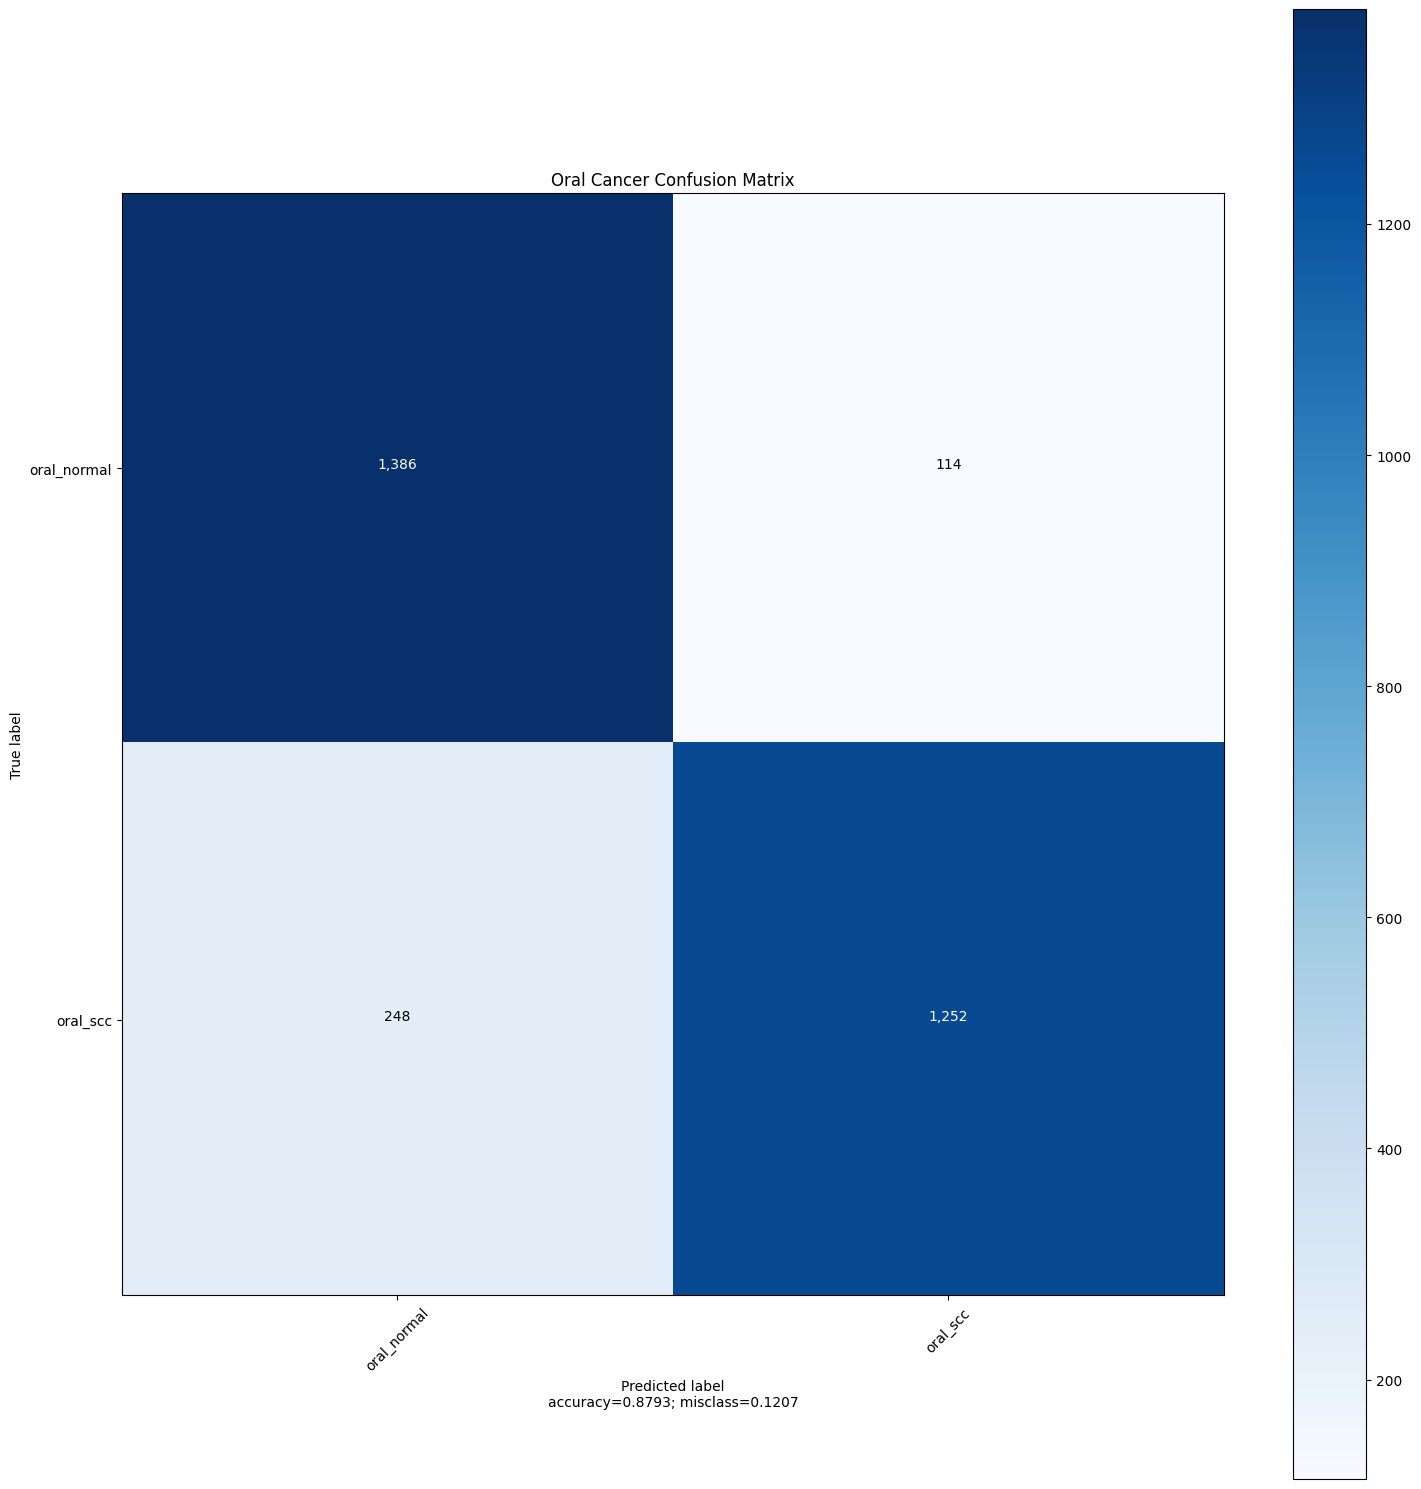

Best Hyperparameters (learning rate, batch size): [9.95284300e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [14]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 14000 images belonging to 4 classes.

For Val :  Found 6000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)    

2024-03-16 11:08:31.657624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


438/438 [==============================] - ETA: 0s - loss: 0.3226 - tp: 11923.0000 - fp: 443.0000 - tn: 41557.0000 - fn: 2077.0000 - precision: 0.9642 - recall: 0.8516 - accuracy: 0.9172 - auc: 0.9903
Epoch 1: val_loss improved from inf to 0.11867, saving model to ALLEfficientNetB0.keras
438/438 [==============================] - 193s 420ms/step - loss: 0.3226 - tp: 11923.0000 - fp: 443.0000 - tn: 41557.0000 - fn: 2077.0000 - precision: 0.9642 - recall: 0.8516 - accuracy: 0.9172 - auc: 0.9903 - val_loss: 0.1187 - val_tp: 5814.0000 - val_fp: 101.0000 - val_tn: 17899.0000 - val_fn: 186.0000 - val_precision: 0.9829 - val_recall: 0.9690 - val_accuracy: 0.9770 - val_auc: 0.9989 - lr: 0.0010
Epoch 2/20
438/438 [==============================] - ETA: 0s - loss: 0.1109 - tp: 13555.0000 - fp: 303.0000 - tn: 41697.0000 - fn: 445.0000 - precision: 0.9781 - recall: 0.9682 - accuracy: 0.9739 - auc: 0.9987
Epoch 2: val_loss improved from 0.11867 to 0.06971, saving model to ALLEfficientNetB0.keras
43

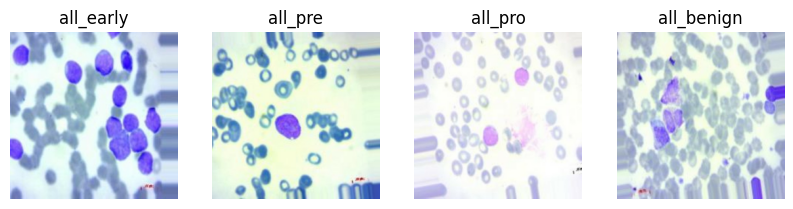

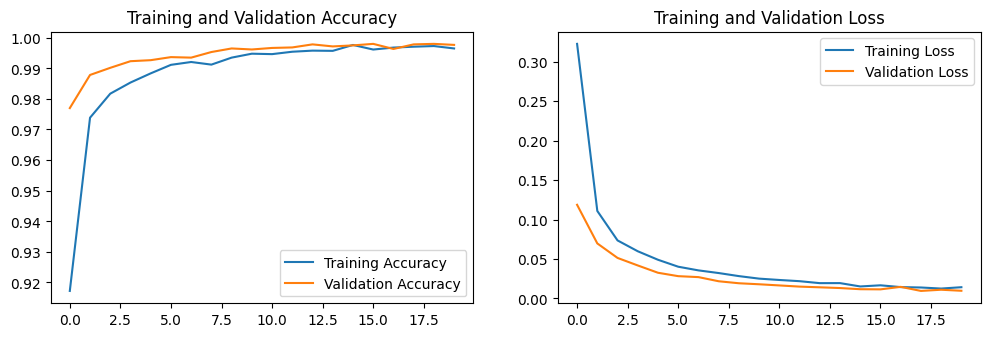

188/188 [==============================] - 22s 114ms/step - loss: 0.0097 - tp: 5985.0000 - fp: 14.0000 - tn: 17986.0000 - fn: 15.0000 - precision: 0.9977 - recall: 0.9975 - accuracy: 0.9977 - auc: 1.0000
Accuracy on the Test Set = 99.77 %
True Positives = 5985.0. True Negatives = 17986.0
False Positives = 14.0. False Negatives = 15.0
Precision = 0.9976662993431091
Recall = 0.9975000023841858
F1 Score = 99.7583143933228
ROC AUC = 0.9999929070472717
Model saved at: /kaggle/working/ALL - EfficientNetB0.keras
True :  [0 0 0 ... 3 3 3]
188/188 [==============================] - 23s 114ms/step
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

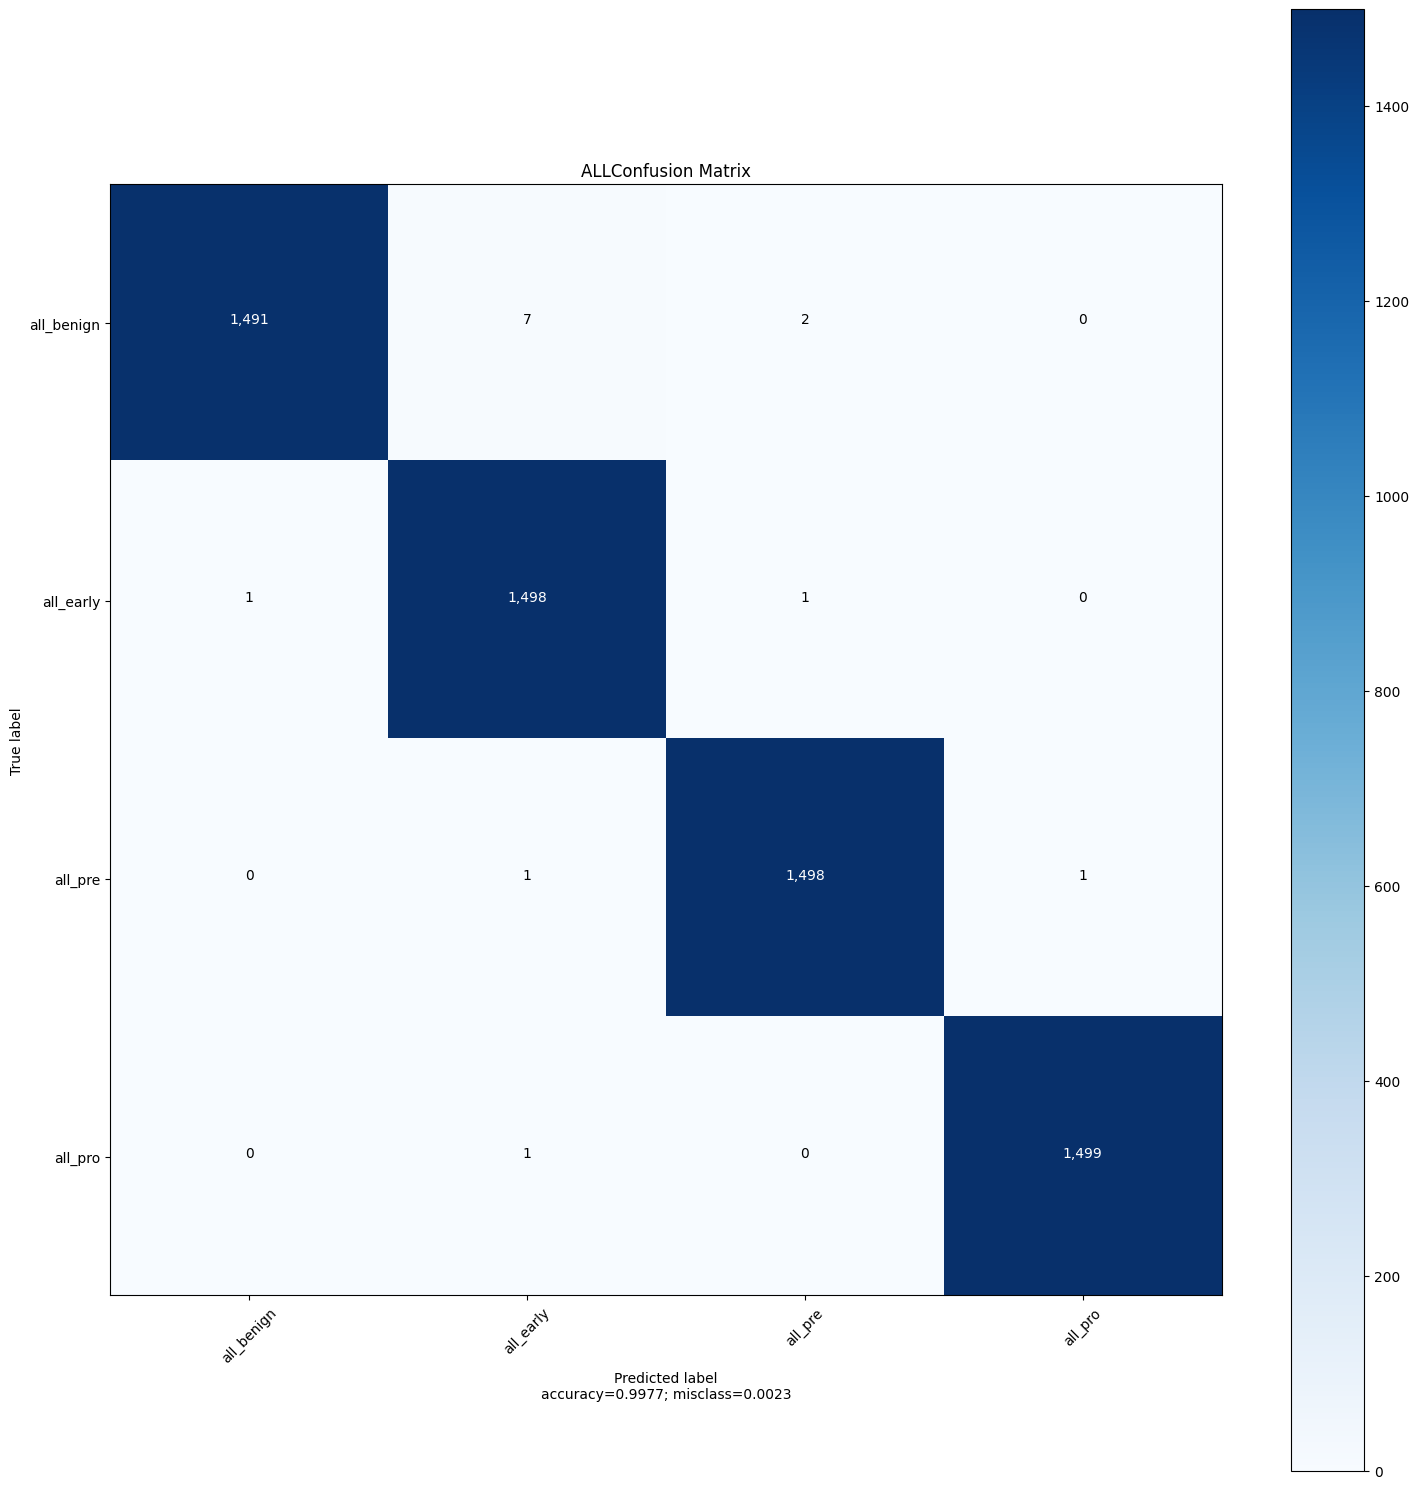

Best Hyperparameters (learning rate, batch size): [9.95285250e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [15]:
className = 'ALL'
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_8[0][0]']         
 tion)                     

2024-03-16 11:34:54.654896: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - ETA: 0s - loss: 0.2032 - tp: 6555.0000 - fp: 445.0000 - tn: 6555.0000 - fn: 445.0000 - precision: 0.9364 - recall: 0.9364 - accuracy: 0.9364 - auc: 0.9857
Epoch 1: val_loss improved from inf to 0.16333, saving model to Kidney Cancer EfficientNetB0.keras
219/219 [==============================] - 111s 470ms/step - loss: 0.2032 - tp: 6555.0000 - fp: 445.0000 - tn: 6555.0000 - fn: 445.0000 - precision: 0.9364 - recall: 0.9364 - accuracy: 0.9364 - auc: 0.9857 - val_loss: 0.1633 - val_tp: 2878.0000 - val_fp: 122.0000 - val_tn: 2878.0000 - val_fn: 122.0000 - val_precision: 0.9593 - val_recall: 0.9593 - val_accuracy: 0.9593 - val_auc: 0.9918 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - ETA: 0s - loss: 0.0733 - tp: 6915.0000 - fp: 85.0000 - tn: 6915.0000 - fn: 85.0000 - precision: 0.9879 - recall: 0.9879 - accuracy: 0.9879 - auc: 0.9991
Epoch 2: val_loss improved from 0.16333 to 0.14676, saving model to Kidney Cancer EfficientNet

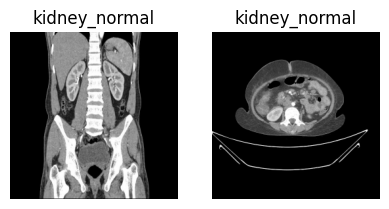

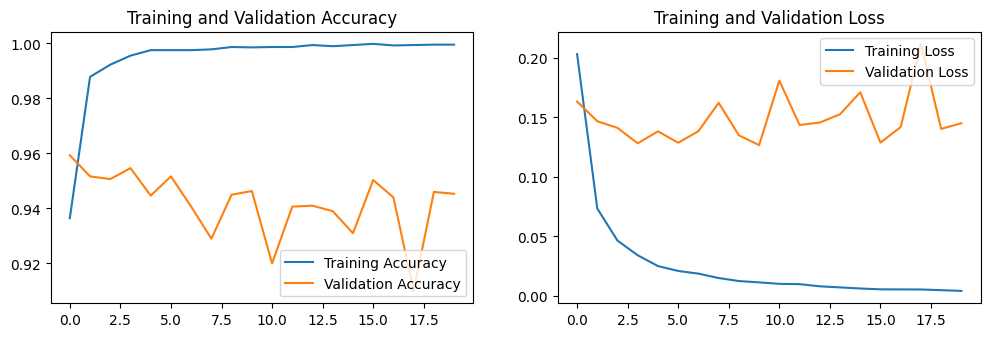

94/94 [==============================] - 10s 106ms/step - loss: 0.1451 - tp: 2836.0000 - fp: 164.0000 - tn: 2836.0000 - fn: 164.0000 - precision: 0.9453 - recall: 0.9453 - accuracy: 0.9453 - auc: 0.9877
Accuracy on the Test Set = 94.53 %
True Positives = 2836.0. True Negatives = 2836.0
False Positives = 164.0. False Negatives = 164.0
Precision = 0.9453333616256714
Recall = 0.9453333616256714
F1 Score = 94.53333616256714
ROC AUC = 0.9876836538314819
Model saved at: /kaggle/working/Kidney Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 12s 104ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

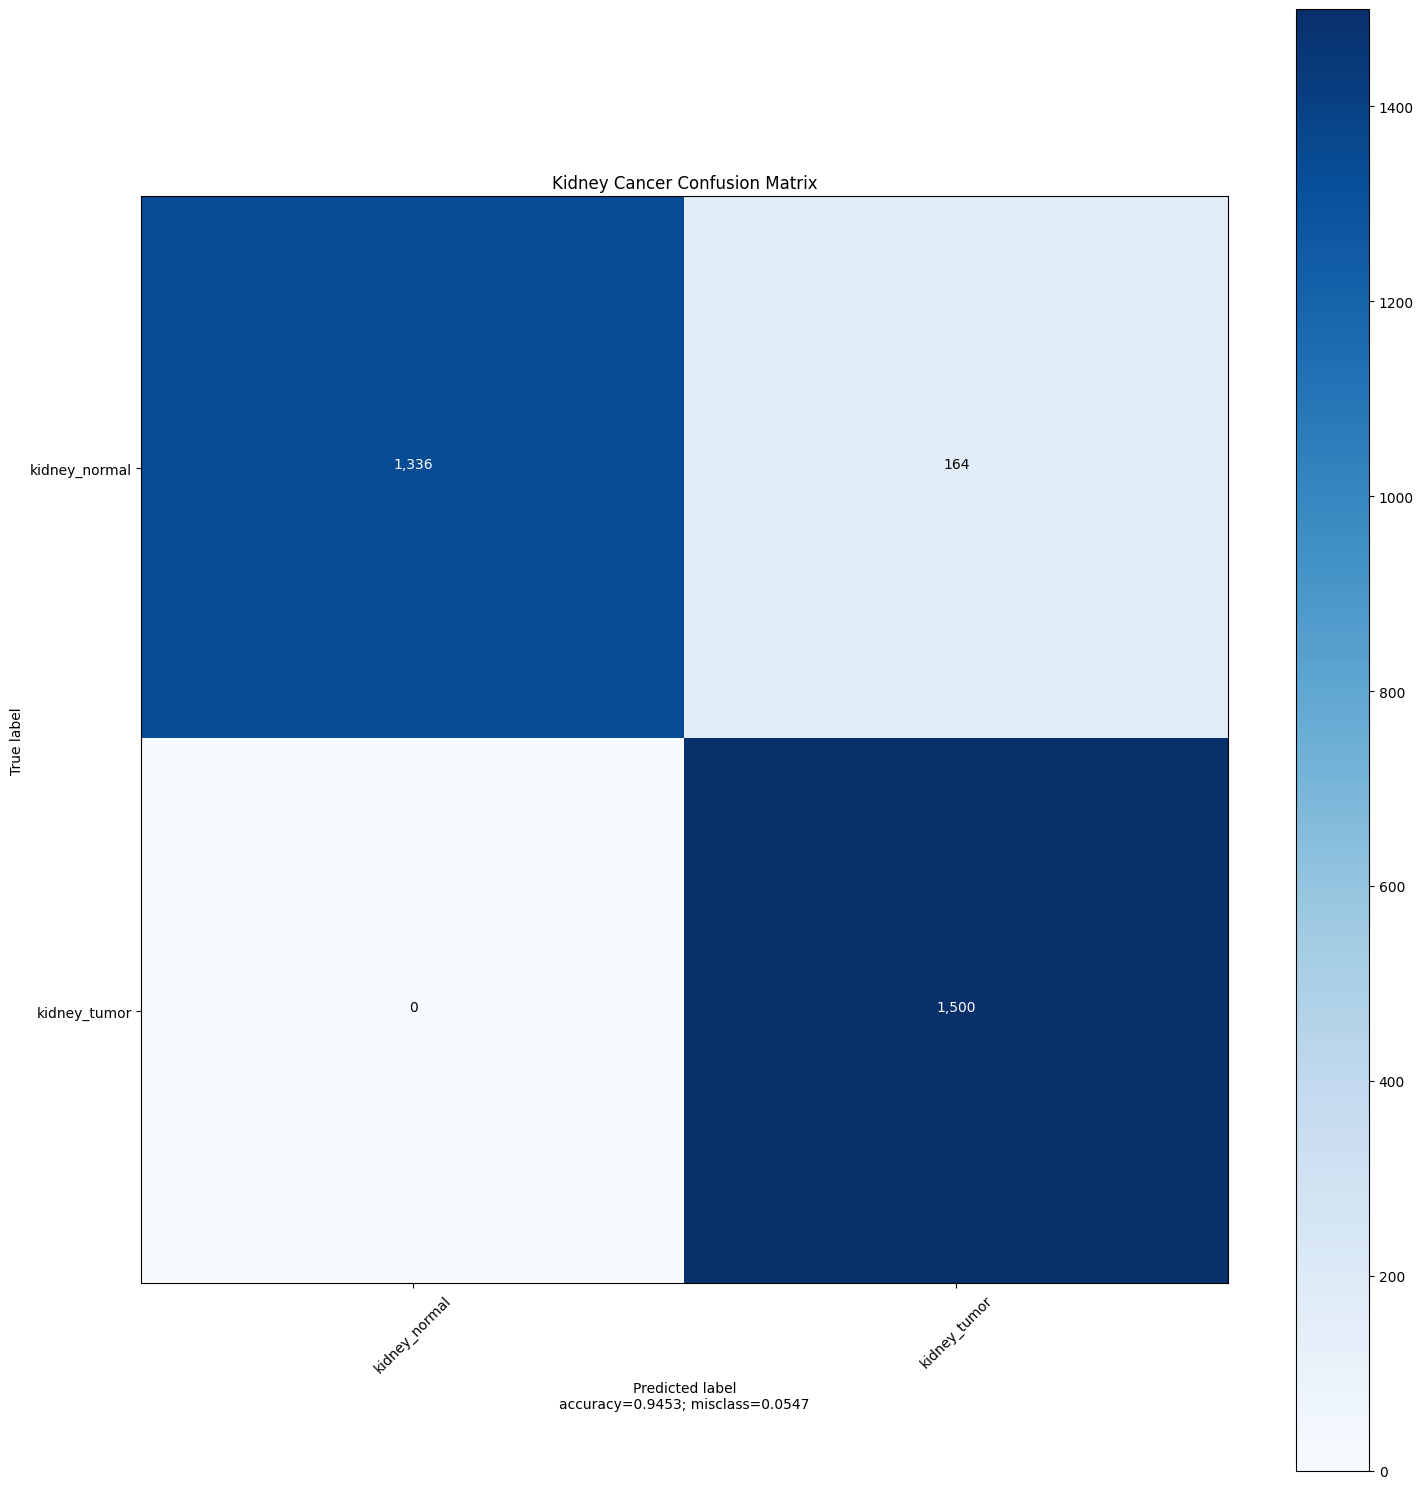

Best Hyperparameters (learning rate, batch size): [9.95285364e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [16]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 normalization_5 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_10[0][0]']        
 tion)                 

2024-03-16 11:48:07.941082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - ETA: 0s - loss: 0.1293 - tp: 6705.0000 - fp: 295.0000 - tn: 6705.0000 - fn: 295.0000 - precision: 0.9579 - recall: 0.9579 - accuracy: 0.9579 - auc: 0.9924
Epoch 1: val_loss improved from inf to 0.07181, saving model to Breast Cancer EfficientNetB0.keras
219/219 [==============================] - 169s 735ms/step - loss: 0.1293 - tp: 6705.0000 - fp: 295.0000 - tn: 6705.0000 - fn: 295.0000 - precision: 0.9579 - recall: 0.9579 - accuracy: 0.9579 - auc: 0.9924 - val_loss: 0.0718 - val_tp: 2936.0000 - val_fp: 64.0000 - val_tn: 2936.0000 - val_fn: 64.0000 - val_precision: 0.9787 - val_recall: 0.9787 - val_accuracy: 0.9787 - val_auc: 0.9972 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - ETA: 0s - loss: 0.0587 - tp: 6878.0000 - fp: 122.0000 - tn: 6878.0000 - fn: 122.0000 - precision: 0.9826 - recall: 0.9826 - accuracy: 0.9826 - auc: 0.9981
Epoch 2: val_loss improved from 0.07181 to 0.05665, saving model to Breast Cancer EfficientNet

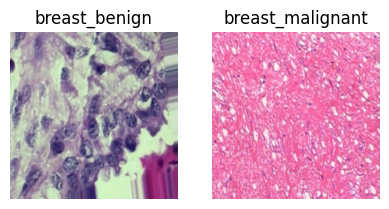

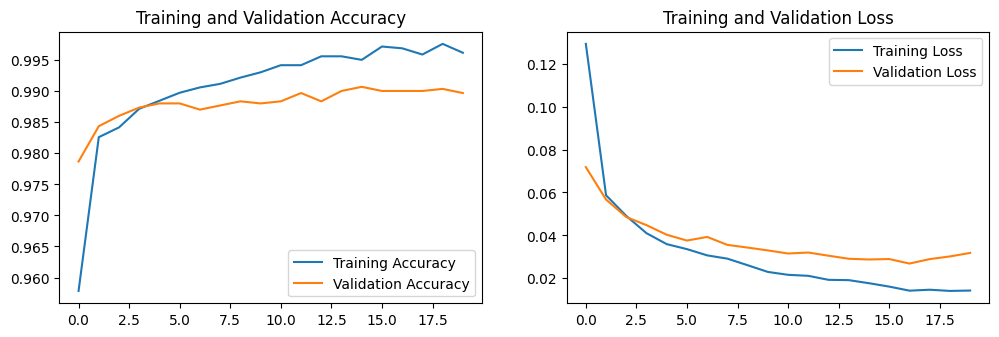

94/94 [==============================] - 25s 261ms/step - loss: 0.0318 - tp: 2969.0000 - fp: 31.0000 - tn: 2969.0000 - fn: 31.0000 - precision: 0.9897 - recall: 0.9897 - accuracy: 0.9897 - auc: 0.9990
Accuracy on the Test Set = 98.97 %
True Positives = 2969.0. True Negatives = 2969.0
False Positives = 31.0. False Negatives = 31.0
Precision = 0.9896666407585144
Recall = 0.9896666407585144
F1 Score = 98.96666407585144
ROC AUC = 0.9990430474281311
Model saved at: /kaggle/working/Breast Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 25s 251ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

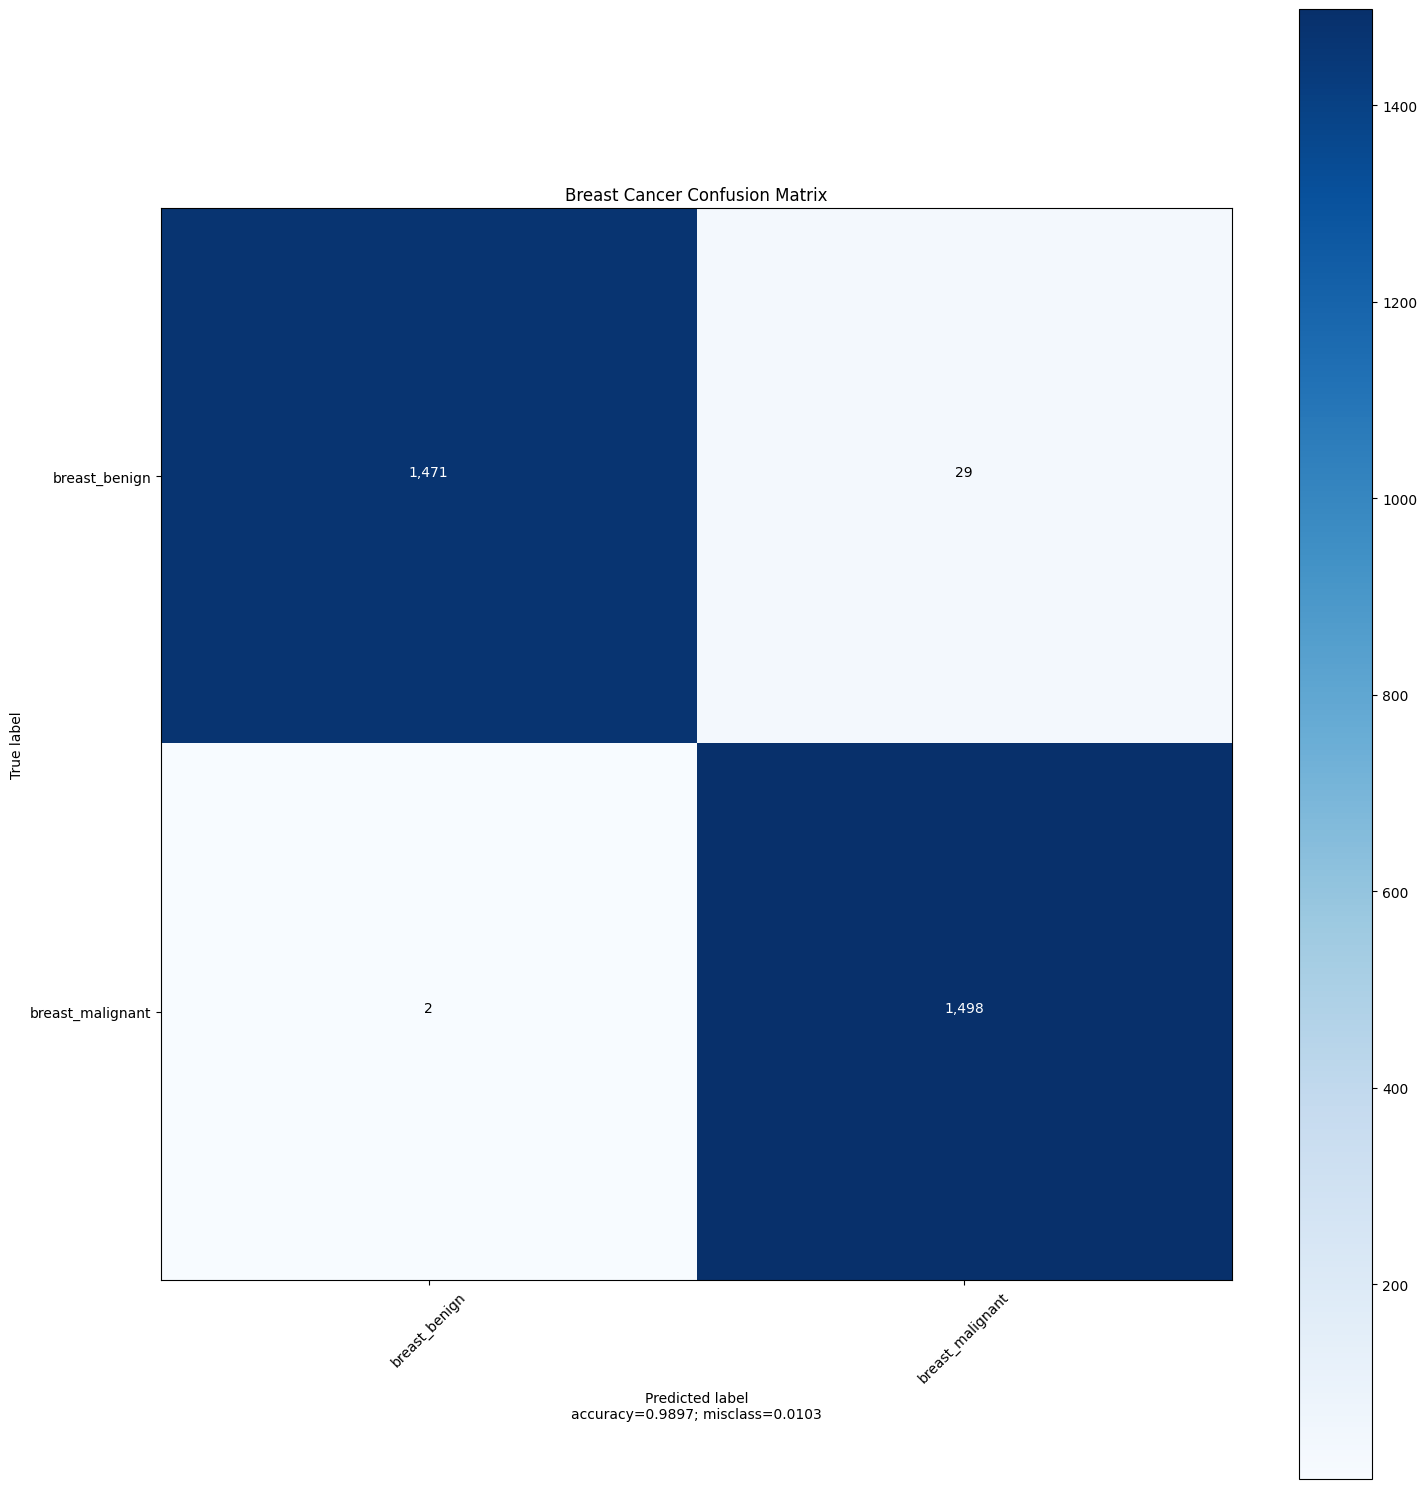

Best Hyperparameters (learning rate, batch size): [9.95284288e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [17]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_12 (Rescaling)    (None, 224, 224, 3)          0         ['input_7[0][0]']             
                                                                                                  
 normalization_6 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_12[0][0]']        
 tion)               

2024-03-16 12:17:27.390412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - ETA: 0s - loss: 0.8036 - tp: 4742.0000 - fp: 1674.0000 - tn: 19326.0000 - fn: 5758.0000 - precision: 0.7391 - recall: 0.4516 - accuracy: 0.6312 - auc: 0.8265
Epoch 1: val_loss improved from inf to 0.66513, saving model to Lymphoma EfficientNetB0.keras
329/329 [==============================] - 169s 489ms/step - loss: 0.8036 - tp: 4742.0000 - fp: 1674.0000 - tn: 19326.0000 - fn: 5758.0000 - precision: 0.7391 - recall: 0.4516 - accuracy: 0.6312 - auc: 0.8265 - val_loss: 0.6651 - val_tp: 2744.0000 - val_fp: 638.0000 - val_tn: 8362.0000 - val_fn: 1756.0000 - val_precision: 0.8114 - val_recall: 0.6098 - val_accuracy: 0.7349 - val_auc: 0.8952 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - ETA: 0s - loss: 0.6407 - tp: 6788.0000 - fp: 1671.0000 - tn: 19329.0000 - fn: 3712.0000 - precision: 0.8025 - recall: 0.6465 - accuracy: 0.7416 - auc: 0.8974
Epoch 2: val_loss improved from 0.66513 to 0.57871, saving model to Lymphoma EfficientN

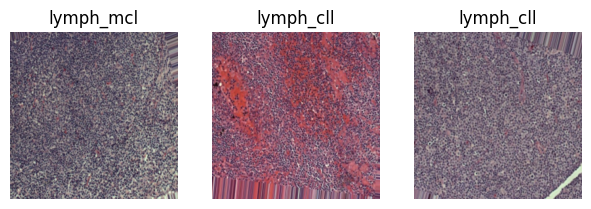

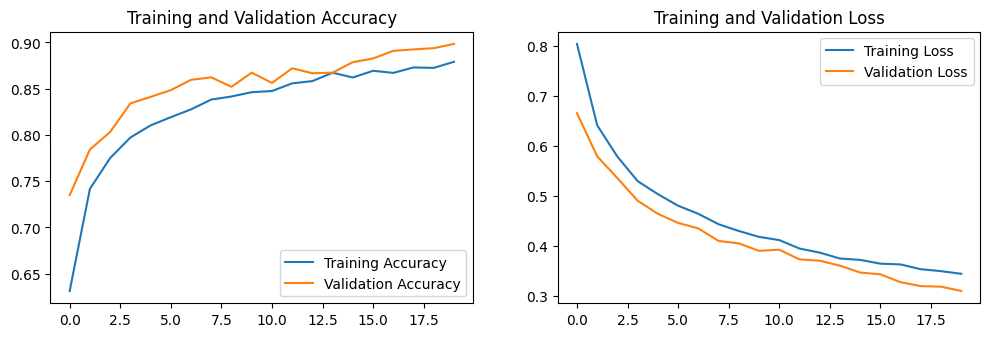

141/141 [==============================] - 20s 139ms/step - loss: 0.3095 - tp: 3940.0000 - fp: 347.0000 - tn: 8653.0000 - fn: 560.0000 - precision: 0.9191 - recall: 0.8756 - accuracy: 0.8984 - auc: 0.9799
Accuracy on the Test Set = 89.84 %
True Positives = 3940.0. True Negatives = 8653.0
False Positives = 347.0. False Negatives = 560.0
Precision = 0.9190576076507568
Recall = 0.8755555748939514
F1 Score = 89.67793392515897
ROC AUC = 0.979902982711792
Model saved at: /kaggle/working/Lymphoma  - EfficientNetB0.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 21s 140ms/step
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

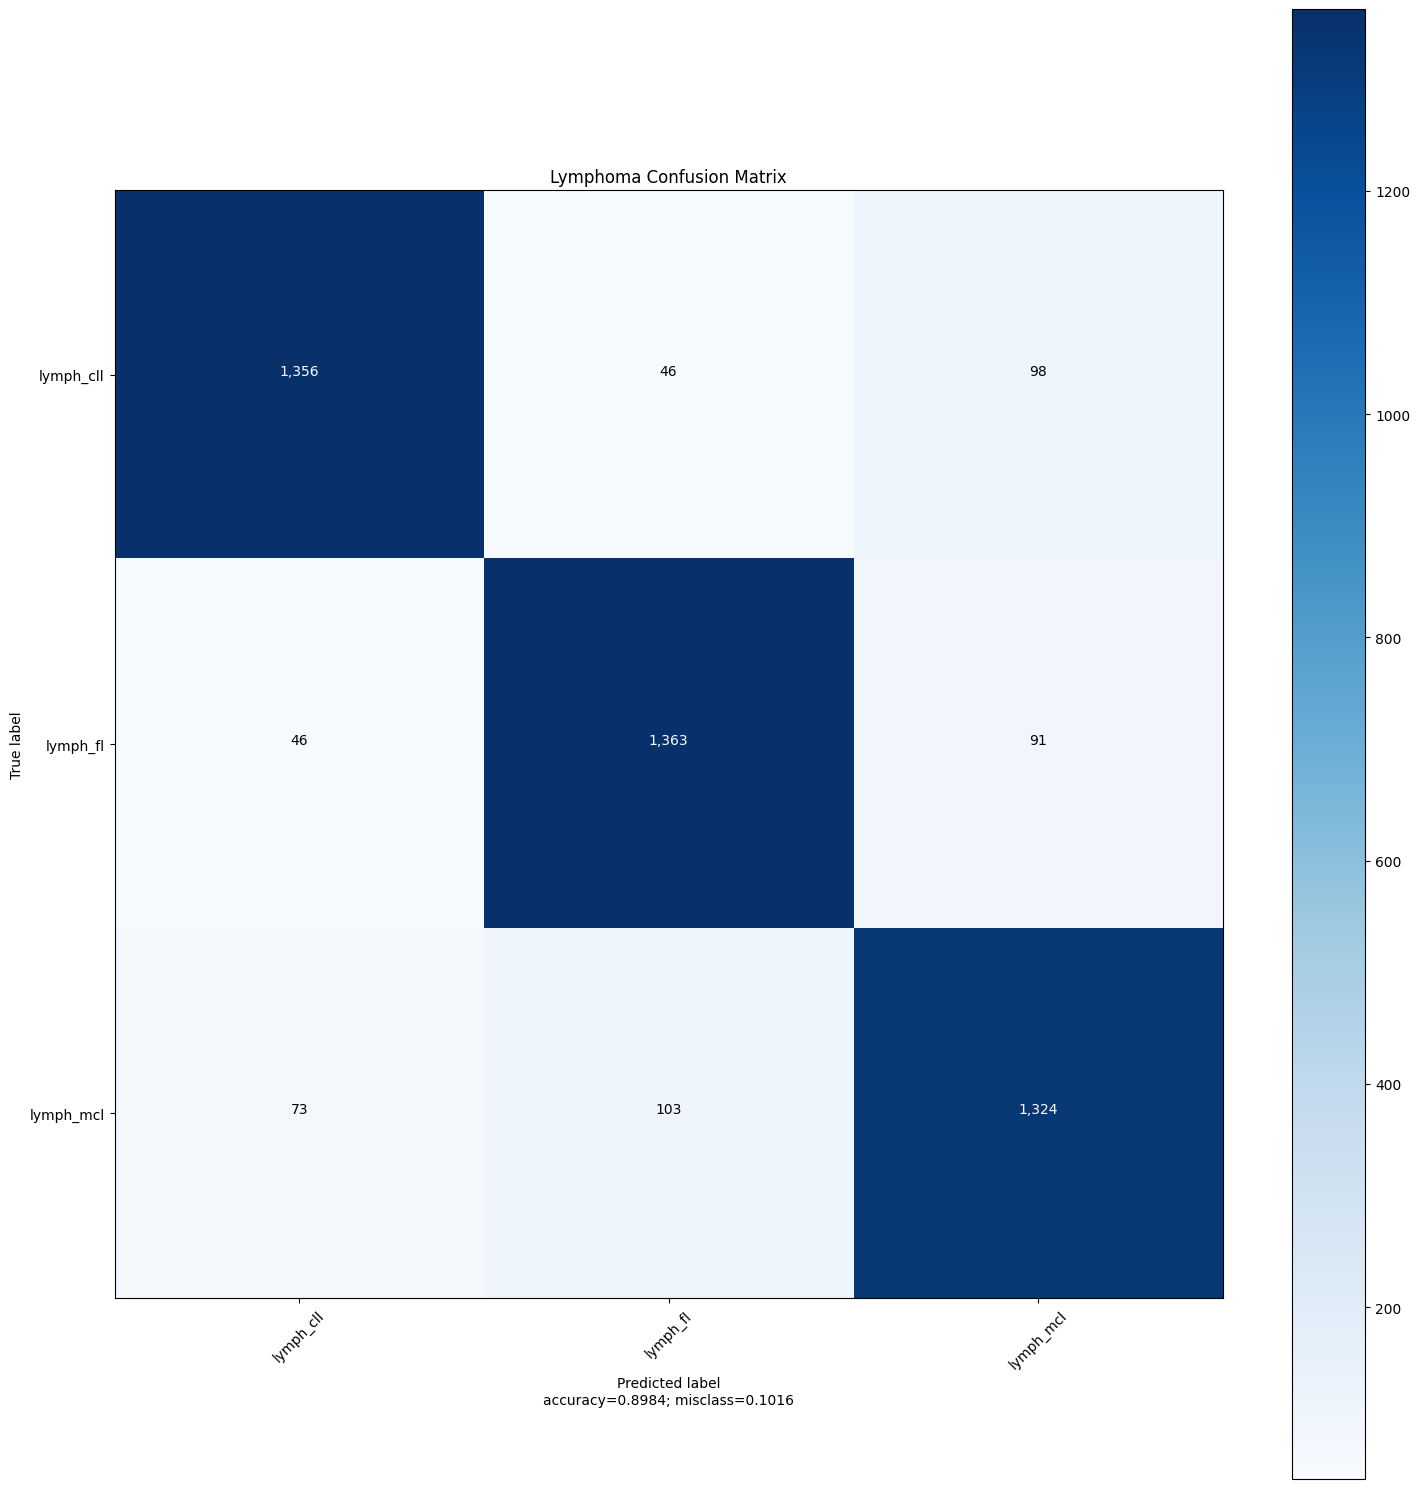

Best Hyperparameters (learning rate, batch size): [9.95285276e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [18]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_14 (Rescaling)    (None, 224, 224, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_7 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_14[0][0]']        
 tion)       

2024-03-16 12:42:06.976285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - ETA: 0s - loss: 0.4248 - tp: 8317.0000 - fp: 1142.0000 - tn: 19858.0000 - fn: 2183.0000 - precision: 0.8793 - recall: 0.7921 - accuracy: 0.8415 - auc: 0.9577
Epoch 1: val_loss improved from inf to 0.26994, saving model to Brain Cancer EfficientNetB0.keras
329/329 [==============================] - 135s 388ms/step - loss: 0.4248 - tp: 8317.0000 - fp: 1142.0000 - tn: 19858.0000 - fn: 2183.0000 - precision: 0.8793 - recall: 0.7921 - accuracy: 0.8415 - auc: 0.9577 - val_loss: 0.2699 - val_tp: 4049.0000 - val_fp: 361.0000 - val_tn: 8639.0000 - val_fn: 451.0000 - val_precision: 0.9181 - val_recall: 0.8998 - val_accuracy: 0.9102 - val_auc: 0.9811 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - ETA: 0s - loss: 0.2449 - tp: 9556.0000 - fp: 766.0000 - tn: 20234.0000 - fn: 944.0000 - precision: 0.9258 - recall: 0.9101 - accuracy: 0.9190 - auc: 0.9848
Epoch 2: val_loss improved from 0.26994 to 0.20531, saving model to Brain Cancer Effic

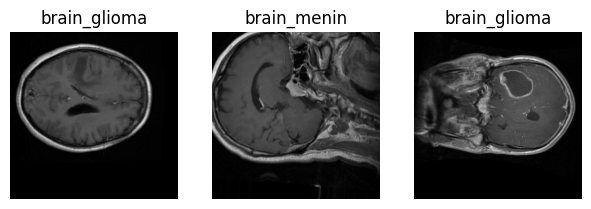

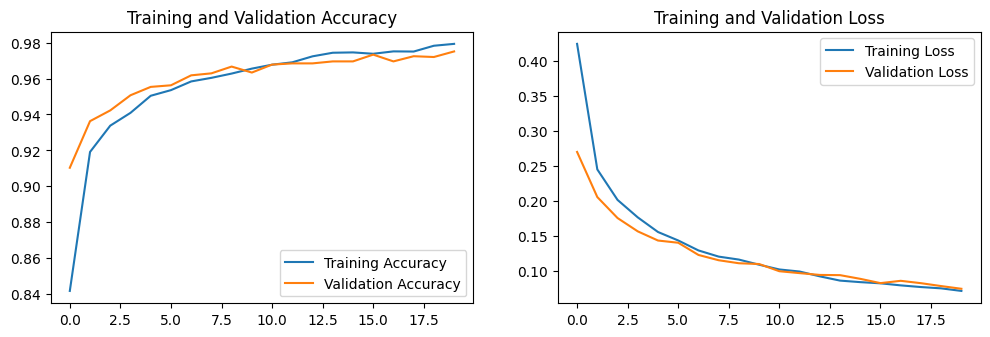

141/141 [==============================] - 13s 94ms/step - loss: 0.0739 - tp: 4386.0000 - fp: 109.0000 - tn: 8891.0000 - fn: 114.0000 - precision: 0.9758 - recall: 0.9747 - accuracy: 0.9751 - auc: 0.9986
Accuracy on the Test Set = 97.51 %
True Positives = 4386.0. True Negatives = 8891.0
False Positives = 109.0. False Negatives = 114.0
Precision = 0.9757508635520935
Recall = 0.9746666550636292
F1 Score = 97.5208457960064
ROC AUC = 0.9986396431922913
Model saved at: /kaggle/working/Brain Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 16s 98ms/step
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

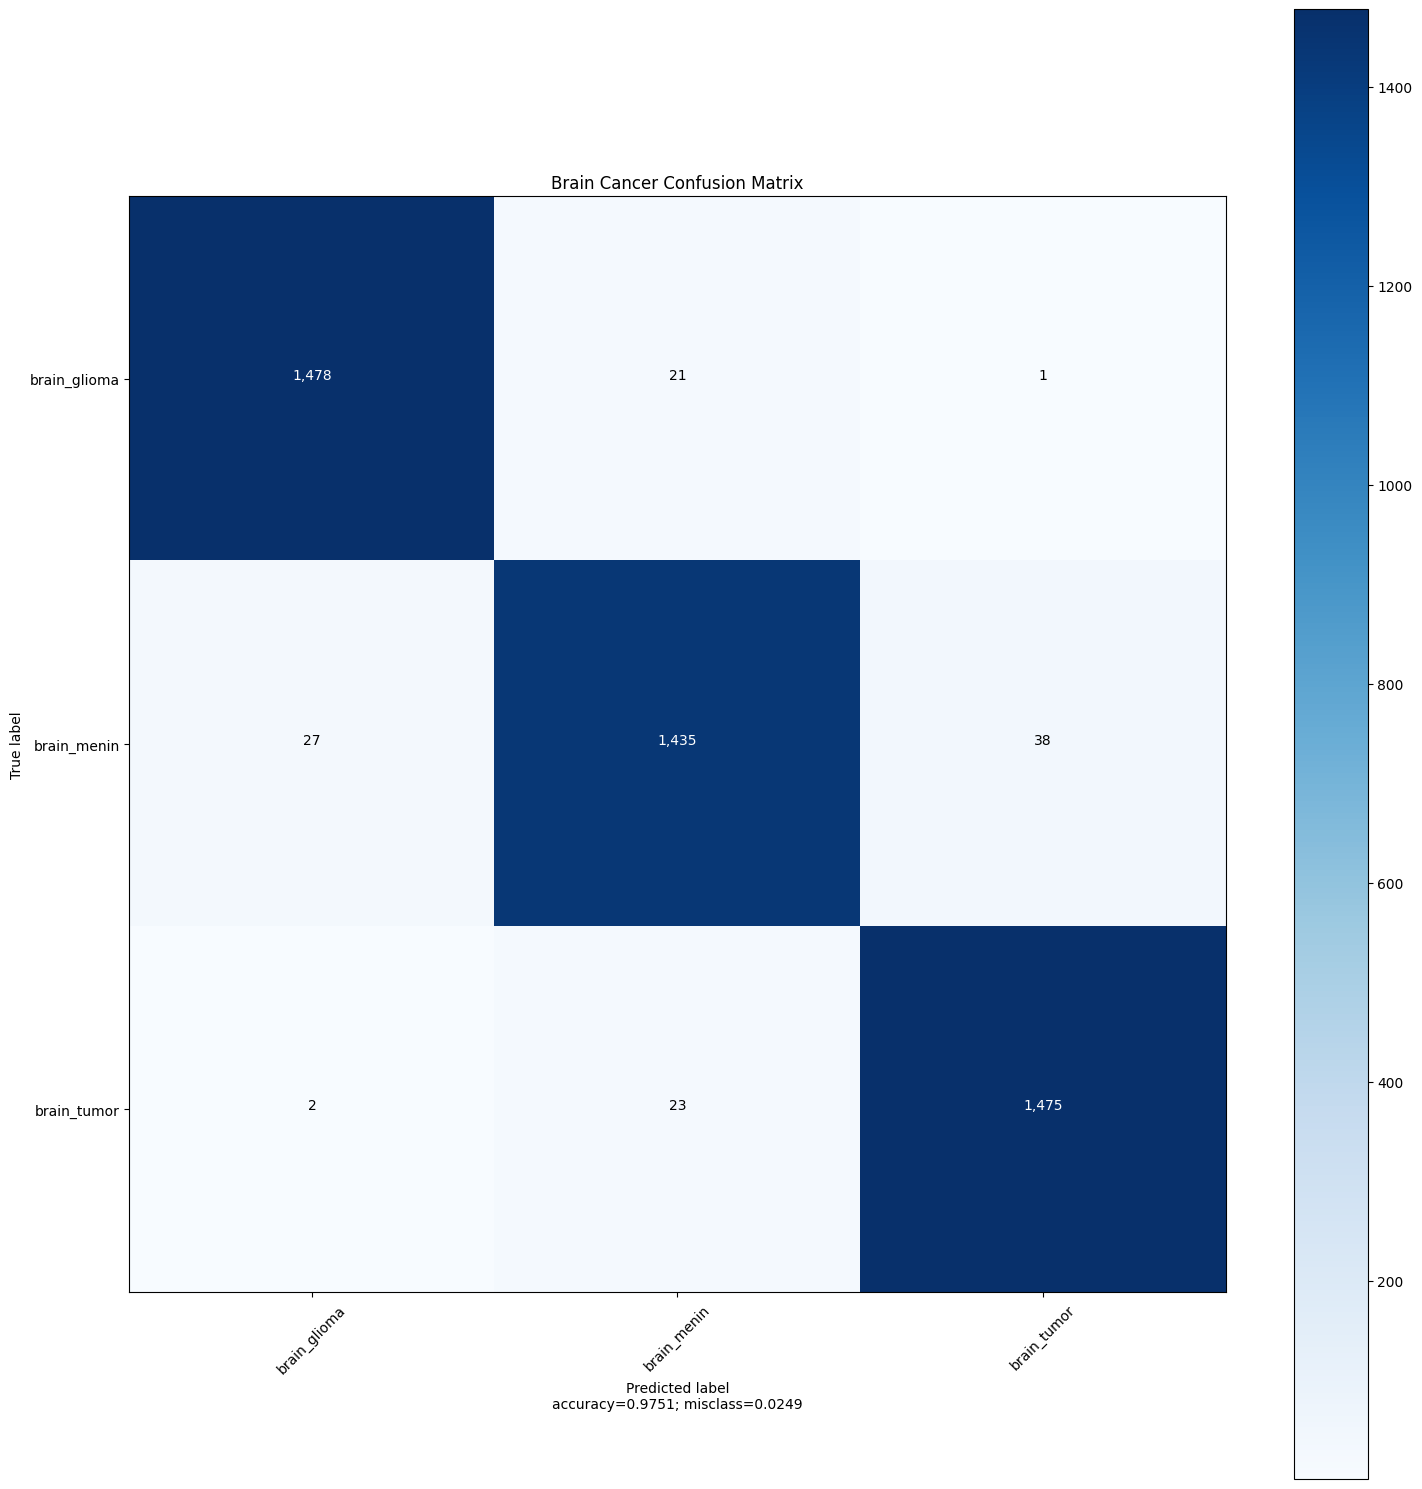

Best Hyperparameters (learning rate, batch size): [9.95284329e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [19]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)